## Datasets and Dataloaders
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data.

**Fashion-MNIST** 
- 28 pixels * 28 pixels
- gray scale 0-255
- 10 classes

In [1]:
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
import torch
import matplotlib.pyplot as plt
%matplotlib inline

training_data = datasets.FashionMNIST(
    root="data",  # root 是train/test存储的位置
    train=True,  # 表明是否是训练集   
    download=True, # download=True downloads the data from the internet if it’s not available at root.
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

每一条training_data是一个tuple，含有图片的tensor和label

In [2]:
print(training_data[0][0].shape)
print(f"label: {training_data[0][1]}")


torch.Size([1, 28, 28])
label: 9


In [3]:
batchsize= 64
# create data_loader
train_dataloader = DataLoader(training_data, batchsize, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batchsize, num_workers=4)

for X,y in test_dataloader:
    print(f"Shape of X [N,C,H,W]: {X.shape}")
    print(f"shape of y: {y.shape}, {y.dtype}")
    print(y)
    
    break    


Shape of X [N,C,H,W]: torch.Size([64, 1, 28, 28])
shape of y: torch.Size([64]), torch.int64
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])


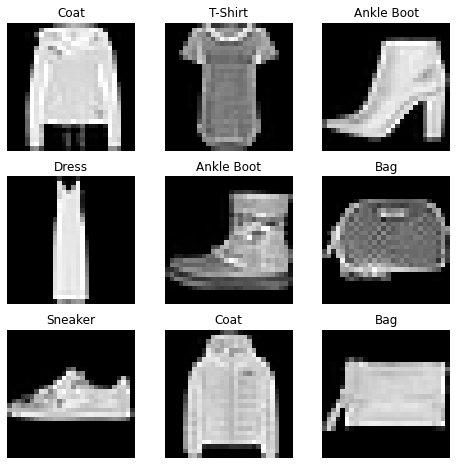

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## custom dataset for your project

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. Take a look at this implementation; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file `annotations_file`.

The labels.csv file looks like:

> tshirt1.jpg, 0  
> tshirt2.jpg, 0  
> ......  
> ankleboot999.jpg, 9  


In [5]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):  
        """loads and returns a sample from the dataset at the given index idx."""
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.image_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Preparing your data for training with DataLoaders




In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")


Using cpu device


In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(  # 各层的用法参考https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


更多loss function见nn module中 https://pytorch.org/docs/stable/nn.html#loss-functions

更多的optimizer见torch.optim https://pytorch.org/docs/stable/optim.html

In [8]:
loss_fn = nn.CrossEntropyLoss()  #交叉熵，用于分类问题，第一个参数是预测的softmax向量，第二个参数是真实的class label
#  更多loss function见nn module中 https://pytorch.org/docs/stable/nn.html#loss-functions
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # set model in train mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss:{loss:>7f} [{current:>5d}/{size:5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # set model in evaluation mode, This is equivalent with self.train(False).
    model.eval()
    testloss = 0
    correct = 0
    with torch.no_grad():
        """关于torch.no_grad()
        Context-manager that disabled gradient calculation.
        
        Disabling gradient calculation is useful for inference, 
        when you are sure that you will not call Tensor.backward(). 
        It will reduce memory consumption for computations that 
        would otherwise have requires_grad=True.
        
        see also https://pytorch.org/docs/stable/generated/torch.no_grad.html
        """ 
        for X,y in dataloader:
            X, y= X.to(device), y.to(device)
            pred= model(X)
            testloss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    testloss /= num_batches
    correct /= size
    print(f"test error: \n Accurancy {(100*correct):>0.1f}%, avg loss: {testloss:>8f}\n")    
    
    
    

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss:2.313266 [    0/60000]
loss:2.294425 [ 6400/60000]
loss:2.278476 [12800/60000]
loss:2.261252 [19200/60000]
loss:2.244133 [25600/60000]
loss:2.227233 [32000/60000]
loss:2.235907 [38400/60000]
loss:2.196400 [44800/60000]
loss:2.171042 [51200/60000]
loss:2.163705 [57600/60000]
test error: 
 Accurancy 41.0%, avg loss: 2.163406

Epoch 2
-------------------------------
loss:2.151978 [    0/60000]
loss:2.154771 [ 6400/60000]
loss:2.107452 [12800/60000]
loss:2.089332 [19200/60000]
loss:2.070731 [25600/60000]
loss:2.053406 [32000/60000]
loss:2.002451 [38400/60000]
loss:1.966296 [44800/60000]
loss:1.971388 [51200/60000]
loss:1.918878 [57600/60000]
test error: 
 Accurancy 56.3%, avg loss: 1.906789

Epoch 3
-------------------------------
loss:1.918681 [    0/60000]
loss:1.891175 [ 6400/60000]
loss:1.819845 [12800/60000]
loss:1.748843 [19200/60000]
loss:1.753563 [25600/60000]
loss:1.728658 [32000/60000]
loss:1.663056 [38400/60000]
loss:1.661188 [44800/6

## save &load models


In [10]:
torch.save(model.state_dict(), "model.pth")  # 这样会存储在当前文件目录下
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


To load model weights, you need to create an instance of the same model first, and then load the parameters using `load_state_dict()` method.

In [11]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))


classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## Saving and Loading Models with Shapes

When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. We might want to save the structure of this class together with the model, in which case we can pass `model` (and not `model.state_dict()`) to the saving function:

## Optimizing the model paramet|ers

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


## tensorboard support

In [19]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

# Extract a batch of 4 images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
#matplotlib_imshow(img_grid, one_channel=True)
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

## Graphing Scalars to Visualize Training

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [25]:
print(len(test_dataloader))
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            net.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(test_dataloader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Turn gradients back on for training

            avg_loss = running_loss / 10
            avg_vloss = running_vloss / len(test_dataloader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(train_dataloader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

157
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Batch 120
Batch 130
Batch 140
Batch 150
Batch 160
Batch 170
Batch 180
Batch 190
Batch 200
Batch 210
Batch 220
Batch 230
Batch 240
Batch 250
Batch 260
Batch 270
Batch 280
Batch 290
Batch 300
Batch 310
Batch 320
Batch 330
Batch 340
Batch 350
Batch 360
Batch 370
Batch 380
Batch 390
Batch 400
Batch 410
Batch 420
Batch 430
Batch 440
Batch 450
Batch 460
Batch 470
Batch 480
Batch 490
Batch 500
Batch 510
Batch 520
Batch 530
Batch 540
Batch 550
Batch 560
Batch 570
Batch 580
Batch 590
Batch 600
Batch 610
Batch 620
Batch 630
Batch 640
Batch 650
Batch 660
Batch 670
Batch 680
Batch 690
Batch 700
Batch 710
Batch 720
Batch 730
Batch 740
Batch 750
Batch 760
Batch 770
Batch 780
Batch 790
Batch 800
Batch 810
Batch 820
Batch 830
Batch 840
Batch 850
Batch 860
Batch 870
Batch 880
Batch 890
Batch 900
Batch 910
Batch 920
Batch 930
Finished Training
